# Assignment 6: Feature selection and regularization

# Total: /100

## Instructions

* Complete the assignment

* Once the notebook is complete, **restart** your kernel and **rerun** your cells

* Submit this notebook to owl by the deadline

* You may use any python library functions you wish to complete the assignment.

In [1]:
# You may need these
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
import sklearn.linear_model as skl
from sklearn import preprocessing
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LassoCV
import matplotlib.pyplot as plt
from IPython.display import display

seed = 2023
np.random.seed(seed)

## Question 1: /20 pts


Customer Lifetime Value (CLV) is the total income a business can expect from a customer over the entire period of their relationship. It’s an important metric as it costs less to keep existing customers than it does to acquire new ones, so increasing the value of your existing customers is a great way to drive growth. We want to predict CLV for an auto insurance company.

1. Read in the `Vehicle_Insurance.csv` dataset and display the last 5 rows.
2. Conduct the required data preparation.

### 1.1 Read the dataset and display the last 5 rows

In [2]:
#
raw_data = pd.read_csv('/content/Vehicle_Insurance.csv')
print(raw_data.tail(5))
raw_data.describe()

              clv  Coverage Gender  Income Marital.Status  \
8625  4100.398533   Premium      F   47761         Single   
8626  3096.511217  Extended      F   21604       Divorced   
8627  8163.890428  Extended      M       0         Single   
8628  7524.442436  Extended      M   21941        Married   
8629  2611.836866  Extended      M       0         Single   

      Monthly.Premium.Auto  Number.of.Open.Complaints  Number.of.Policies  \
8625                   104                          0                   1   
8626                    79                          0                   1   
8627                    85                          3                   2   
8628                    96                          0                   3   
8629                    77                          0                   1   

     Renew.Offer.Type  Total.Claim.Amount  Vehicle.Class  
8625           Offer1          541.282007  Four-Door Car  
8626           Offer1          379.200000  Four-Door

,clv,Income,Monthly.Premium.Auto,Number.of.Open.Complaints,Number.of.Policies,Total.Claim.Amount
count,8630.000000,8630.000000,8630.000000,8630.000000,8630.000000,8630.000000
mean,6725.281515,37586.405794,91.677057,0.389108,3.020626,427.131607
std,3934.876313,30453.838594,32.648209,0.920491,2.445994,282.722326
min,1898.007675,0.000000,61.000000,0.000000,1.000000,0.099007
25%,3858.177183,0.000000,68.000000,0.000000,1.000000,268.881398
50%,5569.220419,33817.000000,81.000000,0.000000,2.000000,376.880363
75%,8456.408530,62250.750000,108.000000,0.000000,4.000000,542.400000
max,21235.445570,99981.000000,298.000000,5.000000,9.000000,2893.239678


### 1.2 Remove the rows with "clv" $> 16000$ as well as those with "clv" $< 2200$ from the dataset. What's the shape of the dataframe now?

In [3]:
#
raw_data.drop(raw_data[raw_data['clv'] > 16000].index, inplace=True)
raw_data.drop(raw_data[raw_data['clv'] < 2200].index, inplace = True)


### 1.3 Using `preprocessing.OneHotEncoder()`, convert all categorical features. Make sure not to add collinear features during the encoding process. Then, display the first 3 rows.

In [4]:

#
transformer = preprocessing.OneHotEncoder(drop='first', handle_unknown='ignore').fit(raw_data[['Coverage', 'Gender', 'Marital.Status', 'Renew.Offer.Type', 'Vehicle.Class']])

cat_Data = transformer.transform(raw_data[['Coverage', 'Gender', 'Marital.Status', 'Renew.Offer.Type', 'Vehicle.Class']])
cat_Data = pd.DataFrame(cat_Data.toarray(), columns=transformer.get_feature_names_out() );

enc_data = pd.concat([raw_data.drop(['Coverage', 'Gender', 'Marital.Status', 'Renew.Offer.Type', 'Vehicle.Class'], 1).reset_index(), cat_Data], 1).drop('index',1)
enc_data

<ipython-input-4-f9fabdd7cd0c>:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  enc_data = pd.concat([raw_data.drop(['Coverage', 'Gender', 'Marital.Status', 'Renew.Offer.Type', 'Vehicle.Class'], 1).reset_index(), cat_Data], 1).drop('index',1)
<ipython-input-4-f9fabdd7cd0c>:7: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  enc_data = pd.concat([raw_data.drop(['Coverage', 'Gender', 'Marital.Status', 'Renew.Offer.Type', 'Vehicle.Class'], 1).reset_index(), cat_Data], 1).drop('index',1)


,clv,Income,Monthly.Premium.Auto,Number.of.Open.Complaints,Number.of.Policies,Total.Claim.Amount,Coverage_Extended,Coverage_Premium,Gender_M,Marital.Status_Married,Marital.Status_Single,Renew.Offer.Type_Offer2,Renew.Offer.Type_Offer3,Renew.Offer.Type_Offer4,Vehicle.Class_Luxury Car,Vehicle.Class_Luxury SUV,Vehicle.Class_SUV,Vehicle.Class_Sports Car,Vehicle.Class_Two-Door Car
0,2763.519279,56274,69,0,1,384.811147,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,6979.535903,0,94,0,8,1131.464935,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,12887.431650,48767,108,0,2,566.472247,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,7645.861827,0,106,0,7,529.881344,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2813.692575,43836,73,0,1,138.130879,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8207,4100.398533,47761,104,0,1,541.282007,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8208,3096.511217,21604,79,0,1,379.200000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8209,8163.890428,0,85,3,2,790.784983,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8210,7524.442436,21941,96,0,3,691.200000,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


)### 1.4 Use `pandas.DataFrame.apply` to apply square root transformation to "Total.Claim.Amount" and log to the target variable. And then, create your `X` and `y`. (No training/test splitting yet) 

In [5]:
#
enc_data['Total.Claim.Amount'] = enc_data['Total.Claim.Amount'].apply(np.sqrt)
enc_data['clv'] = enc_data['clv'].apply(np.log)

X = enc_data.drop('clv',1)
y = enc_data['clv']

<ipython-input-5-308416c76643>:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = enc_data.drop('clv',1)


### 1.5 Build a new design matrix by applying polynomial expansion on the `X` from Question 1.4.

In [6]:
#
polytrans = PolynomialFeatures(degree=2)
X_2 = polytrans.fit_transform(X)
design_X = []
for i in range(len(X_2)):
    design_X.append(X_2[i][1:-1])


### 1.6 Standardize your design matrix (from Question 1.5) with `StandardScaler()`, and store the result into a Pandas dataFrame.

In [7]:
#
sc = StandardScaler().fit_transform(design_X)
polyscDF = pd.DataFrame(sc)

### 1.7 What is the shape of the resultant DataFrame obtained from question 1.6?

In [8]:
#
polyscDF.shape

(8212, 188)

## Question 2: /7 pts

Split the data into training and test sets. Hold out 30% of observations as the test set.  Pass `random_state=seed` to `train_test_split` to ensure you get the same sets per run. The design matrix to pass in to the splitter function is the dataframe whcih you got in Question 1.6. As for the target, you have created it in Question 1.4.

In [9]:
#
X_train, X_test, y_train, y_test = train_test_split(polyscDF, y, test_size=0.3, random_state=seed)
print(y_train.describe().round(2))
len(y_train)

count    5748.00
mean        8.62
std         0.50
min         7.70
25%         8.24
50%         8.61
75%         9.01
max         9.68
Name: clv, dtype: float64


5748

How many observations in your traning data set? What is the average value of the target variable in the traning data set (keep 2 decimal place)?

5748 observations and the mean of the target is 8.62

**YOUR ANSWER HERE:** [2pts]

...

## Question 3: /23 pts

### 3.1 Create a SciKit Learn `Ridge` regression object. Using this object, run a ridge regression analysis of the target variable against all the transformed predictor variables using your training data. Include the arguement `alpha=4.0`. In addition, the ridge regression should be fitted with the intercept.

In [10]:
#
RidgeReg = skl.Ridge(alpha = 4.0, fit_intercept=True)

RidgeReg.fit(X_train,y_train).score(X_test, y_test)

0.56750367531317

### 3.2 Vary the ridge coeficient `alpha` according to the hint. Use `cross_val_score()` to select the best `alpha` based on 'mean_squared_error'. Include the argument `cv=5`. Report the `alpha` that yields the smallest mean_squared_error.   

In [11]:
#
lam = np.exp(np.linspace(-4,1,10))
mean_sq_error_Avg = []
for i in lam:
  mean_sq_error_Avg.append([i, -(cross_val_score(skl.Ridge(alpha = i, fit_intercept=True), X_train, y_train, cv=5,scoring = 'neg_mean_squared_error').mean())])

mean_sq_error_Avg

[[0.01831563888873418, 0.11156882556807868],
 [0.0319224918348957, 0.11155806056929773],
 [0.05563799827784281, 0.11154489576006218],
 [0.0969719678644051, 0.11153050133867155],
 [0.1690133154060661, 0.11151599381582993],
 [0.29457482831010734, 0.11150172133392251],
 [0.5134171190325921, 0.11148759029293047],
 [0.8948393168143701, 0.11147457520632176],
 [1.559623497606781, 0.11146715907829548],
 [2.718281828459045, 0.11147709409113753]]

### 3.3 Re-fit the ridge regression with `alpha` being the value obtained in the previous question. `Print` the first 3 parameters of your model.

In [12]:
#

RidgeReg = skl.Ridge(alpha = 1.559623497606781, fit_intercept=True).fit(X_train, y_train)
RidgeReg.coef_[0:3]

array([0.02840103, 0.33071394, 0.02778553])

### 3.4 Fit the linear regression without any penalty, and the regression should be fitted with the intercept. `Print` the first 3 parameters of your model.

In [13]:
#
noPen = skl.Ridge(alpha = 0, fit_intercept=True).fit(X_train, y_train)
noPen.coef_[0:3]

array([0.01541357, 0.24335571, 0.00828896])

Comparing the parameters that you obtain in questions 3.3 and 3.4, what do you find?

**YOUR ANSWER HERE:** [2pts]

When we remove the penalty the strenght of prediction of  the variables is dropped at least within the first three
...

### 3.5 Use your trained model from Question 3.4 to predict over the test set and `print` the first 5 prediction values.

In [14]:
#
noPenPred = noPen.predict(X_test)
noPenPred[0:3]

array([9.15619122, 8.29791485, 8.86908185])

## Question 4: /25 pts

### 4.1 Consider to fit a Lasso regression to the train dataset. Use `lasso_path()` to show the full path of the first 20 coefficients of the Lasso regression. Include the arguement `eps=8e-3` and `n_alphas=50`.

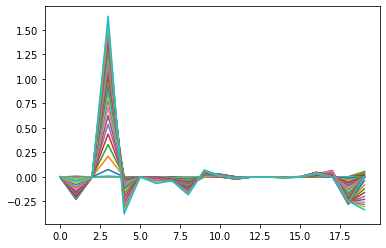

In [15]:
# Draw a plot to show the path. Legend is not required in the plot.
_,coefs_lasso, _ = skl.lasso_path(eps=8e-3 , n_alphas=50,X= X_train,y = y_train)

plt.plot(coefs_lasso[:20])


Describe the trend that shows in your figure.

**YOUR ANSWER HERE:** [3pts] 

It applies that a bulk of the features have the strongest correlation at degree four

### 4.2 Use the Scikit Learn's cross-validated LASSO to automatically search for the best tuning parameter of the LASSO regression on the training set with intercept. Include arguments `eps=8e-3`, `n_alphas=30`, `tol=0.001`, `cv=5`, and `random_state=seed`. Report the best tuning parameter and the number of the non-zero coefficients in the model.

In [16]:
#
lassocv = LassoCV(eps=8e-3, n_alphas=30, tol=0.001, cv=5, random_state=seed).fit(X_train, y_train)
print('Best Alpha: ', lassocv.alpha_, ' Num of none zero', np.count_nonzero(lassocv.coef_) )


Best Alpha:  0.0019347932826026507  Num of none zero 92


### 4.3 Use the Scikit Learn's cross-validated ElasticNet to automatically search for the best tuning parameters of the Elasticnet regression with intercept on the training data set. Include the same argument as question 4.2 as well as `l1_ratio=[.7, .9, .95, .99,1]`. Report the best tuning parameters.

In [17]:
#
ElasticNetCV = skl.ElasticNetCV(l1_ratio=[.7, .9, .95, .99,1],eps=8e-3, n_alphas=30, tol=0.001, cv=5, random_state=seed).fit(X_train, y_train)
print('Best Alpha: ', ElasticNetCV.alpha_, ' Best L1', ElasticNetCV.l1_ratio_ )

Best Alpha:  0.0019347932826026507  Best L1 1.0


From the obtained tuning parameters, is the Elasticnet regression model equivalent to the Lasso regression? Briefly describe the reason. 


**YOUR ANSWER HERE:** [3pts]

They're virtually equivalent as they both have the same alpha and since its 1:0 l1:l2 meaning its fully l1 just as the lasso function 

## Question 5: /16 pts

### 5.1 Start from the regression model in question 3.4, use `SequentialFeatureSelector()` to conduct the forward selection for the features of the regression model. Include the argument `n_features_to_select=20`. Report the indices of the selected features. 

FYI: Running this using 8 physical cores took about 1 minute for me.

In [18]:
#
sfs = SequentialFeatureSelector(noPen, n_features_to_select=20, n_jobs = 4)
sfs.fit(X_train, y_train)
sfs.get_support(indices = True)

array([  1,   3,  12,  18,  19,  20,  28,  36,  38,  55,  59,  69,  75,
       104, 117, 118, 119, 126, 131, 143])

What do you need to change about the argument in your model if you want to conduct a backward selection?

**YOUR ANSWER HERE:** [2pts] 

Change direction argument in SequentialFeatureSelector to negative

### 5.2 Re-fit the regular linear regression based on the traning set by using the selected features from the question 5.1. Report the first 3 parameters of your model as indicated with the print function.

In [19]:
#
SeqFet = noPen.fit(X_train[[  1,   3,  12,  18,  19,  20,  28,  36,  38,  55,  59,  69,  75,
       104, 117, 118, 119, 126, 131, 143]],y_train)
SeqFet.coef_[0:3]

array([ 0.48181157,  1.07122953, -0.0122778 ])

## Question 6: /9 pts

### 6.1 Make predictions on the test set using your models in questions 3.3, 4.2, 4.3, and 5.2, respectively. Together with the predicted values obtained in question 3.5, report the first 5 rows of predicted values obtained from different models in a single DataFrame.

In [20]:
#
modelsPred = pd.DataFrame()
modelsPred['3.3'] = RidgeReg.predict(X_test)
modelsPred['4.2'] = lassocv.predict(X_test)
modelsPred['4.3'] = ElasticNetCV.predict(X_test)
modelsPred['5.2'] =  SeqFet.predict(X_test[[  1,   3,  12,  18,  19,  20,  28,  36,  38,  55,  59,  69,  75,
       104, 117, 118, 119, 126, 131, 143]])

In [21]:
modelsPred[0:5]

,3.3,4.2,4.3,5.2
0,9.244244,9.142903,9.142903,9.197035
1,8.317209,8.303288,8.303288,8.300987
2,8.894473,8.859596,8.859596,8.910826
3,8.083843,8.085032,8.085032,8.025311
4,8.433515,8.416404,8.416404,8.445480


### 6.2 Use `mean_squared_error()` to assess the performance of different models based on all the predicted values mentioned in Question 6.1.  

In [22]:
#
ridge_mse = metrics.mean_squared_error(modelsPred['3.3'], y_test)
lasso_mse = metrics.mean_squared_error(modelsPred['4.2'], y_test)
elastic_mse = metrics.mean_squared_error(modelsPred['4.3'], y_test)
seqFet_mse = metrics.mean_squared_error(modelsPred['5.2'], y_test)

print("{} Least Mean Squared {}".format(['ridge', 'lasso', 'elastic', 'seqfet'], [ridge_mse,lasso_mse,elastic_mse,seqFet_mse]))

['ridge', 'lasso', 'elastic', 'seqfet'] Least Mean Squared [0.1101502080118253, 0.10992600726531618, 0.10992600726531618, 0.11077019282893096]


Which model yields the smallest mean squared error on the test dataset?

**YOUR ANSWER HERE:** [2pts]

Smallest mean squared error on the test is both elastic and lasso since they are the same